In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day_str: str) -> str:
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [6]:

def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day_str)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 178524
New cases registered today: 2246
New cases registered today in %: 1.27
Doubling time in the last five days: 37.2
Doubling time yesterday: 35.8
Trend of new cases (in %) in the last 5 days: 9.77


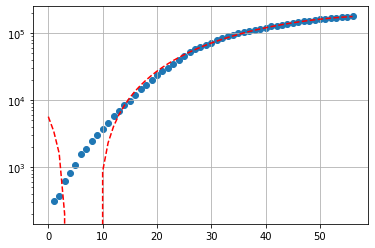

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 2612
New cases registered today: 91
New cases registered today in %: 3.61
Doubling time in the last five days: 25.0
Doubling time yesterday: 29.9
Trend of new cases (in %) in the last 5 days: 14.86


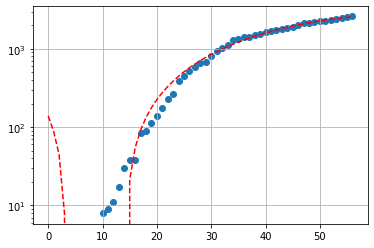

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 1.5572
Total cases up to today: 606
New cases registered today: 35
New cases registered today in %: 6.13
Doubling time in the last five days: 13.5
Doubling time yesterday: 17.6
Trend of new cases (in %) in the last 5 days: 29.21


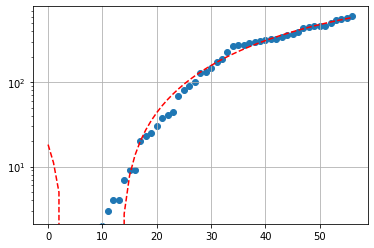

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.785
Total cases up to today: 237
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 100.9
Doubling time yesterday: 89.5
Trend of new cases (in %) in the last 5 days: 3.49


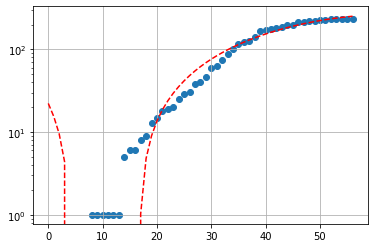

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 3.5573
Total cases up to today: 1143
New cases registered today: 49
New cases registered today in %: 4.48
Doubling time in the last five days: 21.3
Doubling time yesterday: 24.0
Trend of new cases (in %) in the last 5 days: 17.71


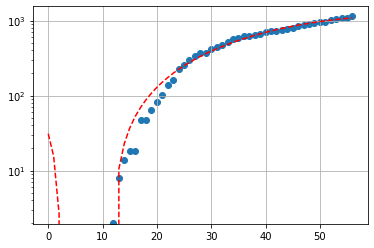

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 2.0203
Total cases up to today: 626
New cases registered today: 7
New cases registered today in %: 1.13
Doubling time in the last five days: 101.6
Doubling time yesterday: 117.4
Trend of new cases (in %) in the last 5 days: 3.47


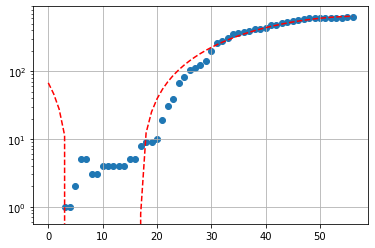

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 342
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 52.1
Doubling time yesterday: 49.8
Trend of new cases (in %) in the last 5 days: 6.88


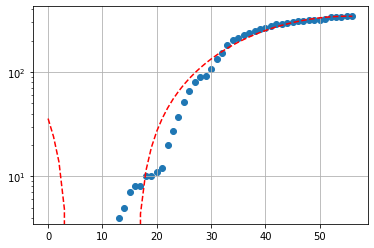

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.8714
Total cases up to today: 174
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 30.0
Doubling time yesterday: 30.0
Trend of new cases (in %) in the last 5 days: 12.26


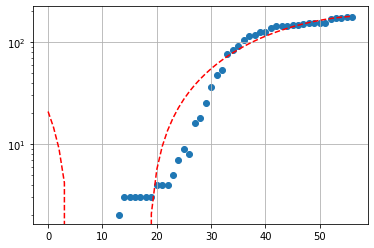

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.4532
Total cases up to today: 168
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 192.3
Doubling time yesterday: 143.8
Trend of new cases (in %) in the last 5 days: 1.82


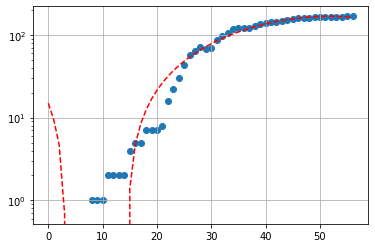

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 2394
New cases registered today: 14
New cases registered today in %: 0.59
Doubling time in the last five days: 47.1
Doubling time yesterday: 40.3
Trend of new cases (in %) in the last 5 days: 7.64


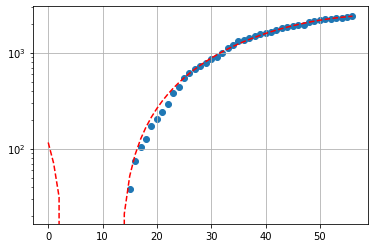

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 1036
New cases registered today: 3
New cases registered today in %: 0.29
Doubling time in the last five days: 51.8
Doubling time yesterday: 43.6
Trend of new cases (in %) in the last 5 days: 6.91


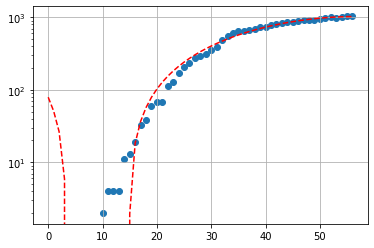

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.5437
Total cases up to today: 197
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 95.8
Doubling time yesterday: 50.8
Trend of new cases (in %) in the last 5 days: 3.68


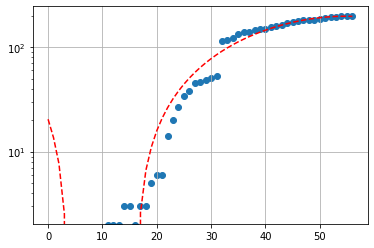

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.5732
Total cases up to today: 408
New cases registered today: 1
New cases registered today in %: 0.25
Doubling time in the last five days: 13.9
Doubling time yesterday: 13.9
Trend of new cases (in %) in the last 5 days: 28.3


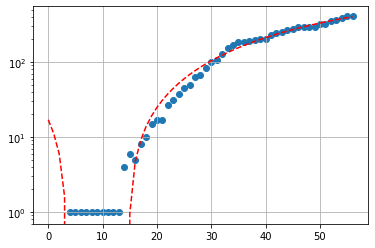

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.6664
Total cases up to today: 117
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: 0.0


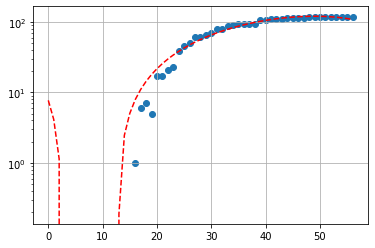

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.4387
Total cases up to today: 243
New cases registered today: 2
New cases registered today in %: 0.83
Doubling time in the last five days: -27.2
Doubling time yesterday: -32.6
Trend of new cases (in %) in the last 5 days: -11.96


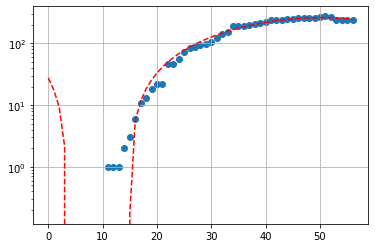

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.4393
Total cases up to today: 71
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 80.3
Doubling time yesterday: 80.3
Trend of new cases (in %) in the last 5 days: 4.41


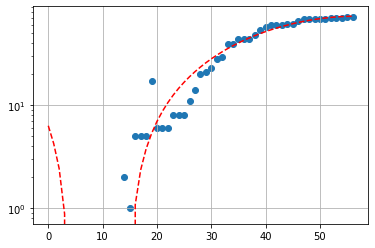

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 3800
New cases registered today: 40
New cases registered today in %: 1.06
Doubling time in the last five days: 49.7
Doubling time yesterday: 51.0
Trend of new cases (in %) in the last 5 days: 7.22


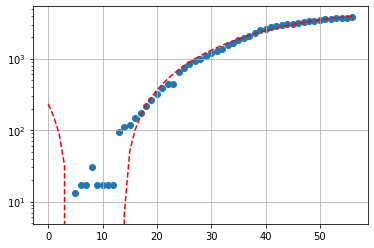

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 1.0083
Total cases up to today: 427
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 72.2
Doubling time yesterday: 57.4
Trend of new cases (in %) in the last 5 days: 4.91


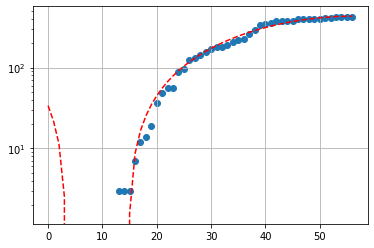

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.6078
Total cases up to today: 170
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 43.6
Doubling time yesterday: 43.6
Trend of new cases (in %) in the last 5 days: 8.28


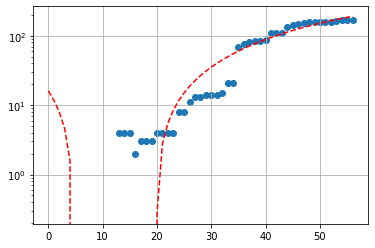

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.4328
Total cases up to today: 400
New cases registered today: 3
New cases registered today in %: 0.76
Doubling time in the last five days: 136.9
Doubling time yesterday: 135.8
Trend of new cases (in %) in the last 5 days: 2.56


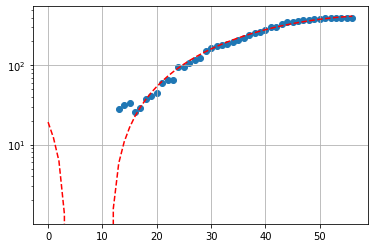

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.702
Total cases up to today: 2181
New cases registered today: 22
New cases registered today in %: 1.02
Doubling time in the last five days: 47.0
Doubling time yesterday: 48.5
Trend of new cases (in %) in the last 5 days: 7.65


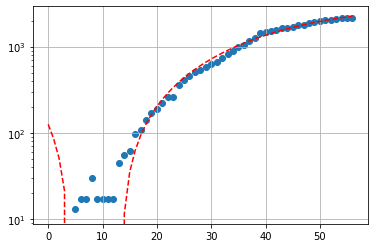

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.563
Total cases up to today: 622
New cases registered today: 15
New cases registered today in %: 2.47
Doubling time in the last five days: 35.4
Doubling time yesterday: 40.3
Trend of new cases (in %) in the last 5 days: 10.28


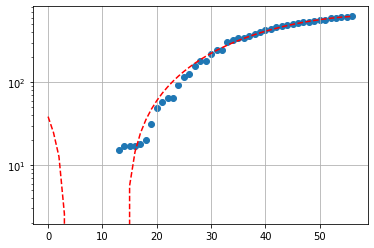

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 0
New cases registered today: 0
Doubling time in the last five days: nan
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: nan


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


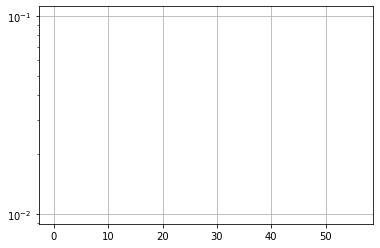

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 3.7871
Total cases up to today: 3822
New cases registered today: 82
New cases registered today in %: 2.19
Doubling time in the last five days: 28.2
Doubling time yesterday: 29.1
Trend of new cases (in %) in the last 5 days: 13.08


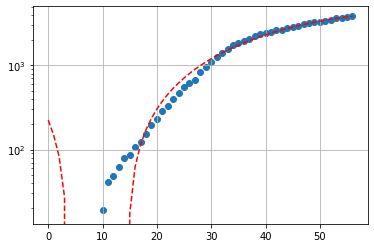

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 2.2591
Total cases up to today: 787
New cases registered today: 16
New cases registered today in %: 2.08
Doubling time in the last five days: 18.0
Doubling time yesterday: 17.9
Trend of new cases (in %) in the last 5 days: 21.26


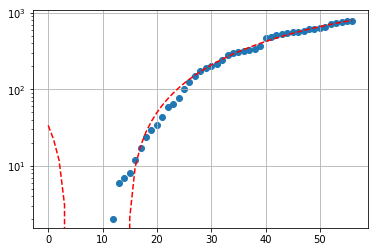

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 4.8669
Total cases up to today: 3411
New cases registered today: 21
New cases registered today in %: 0.62
Doubling time in the last five days: 59.2
Doubling time yesterday: 54.2
Trend of new cases (in %) in the last 5 days: 6.03


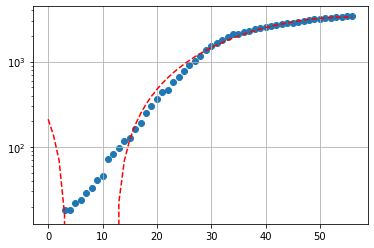

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 6.4313
Total cases up to today: 2887
New cases registered today: 74
New cases registered today in %: 2.63
Doubling time in the last five days: 35.2
Doubling time yesterday: 40.4
Trend of new cases (in %) in the last 5 days: 10.36


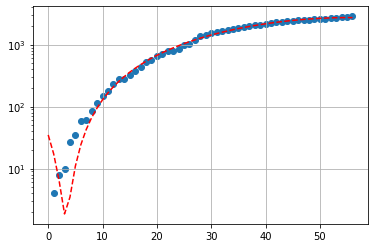

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 11.8323
Total cases up to today: 3393
New cases registered today: 24
New cases registered today in %: 0.71
Doubling time in the last five days: 67.4
Doubling time yesterday: 56.1
Trend of new cases (in %) in the last 5 days: 5.27


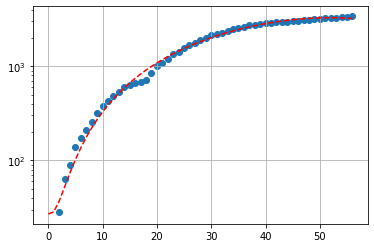

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 2.3862
Total cases up to today: 934
New cases registered today: 8
New cases registered today in %: 0.86
Doubling time in the last five days: 70.2
Doubling time yesterday: 68.0
Trend of new cases (in %) in the last 5 days: 5.06


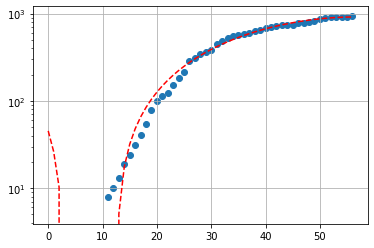

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 8.173
Total cases up to today: 4352
New cases registered today: 34
New cases registered today in %: 0.79
Doubling time in the last five days: 39.0
Doubling time yesterday: 38.6
Trend of new cases (in %) in the last 5 days: 9.29


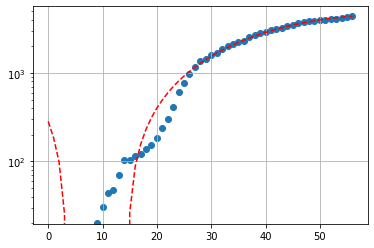

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 5.4812
Total cases up to today: 1846
New cases registered today: 28
New cases registered today in %: 1.54
Doubling time in the last five days: 64.2
Doubling time yesterday: 79.0
Trend of new cases (in %) in the last 5 days: 5.55


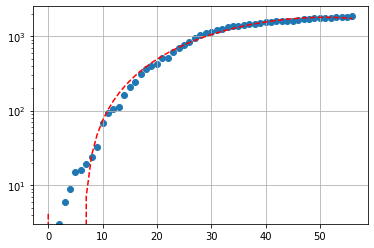

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 2771
New cases registered today: 30
New cases registered today in %: 1.09
Doubling time in the last five days: 39.6
Doubling time yesterday: 40.3
Trend of new cases (in %) in the last 5 days: 9.14


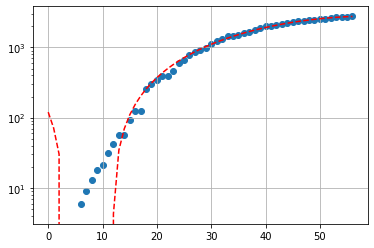

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.988
Total cases up to today: 138
New cases registered today: 6
New cases registered today in %: 4.55
Doubling time in the last five days: 58.0
Doubling time yesterday: 150.8
Trend of new cases (in %) in the last 5 days: 6.15


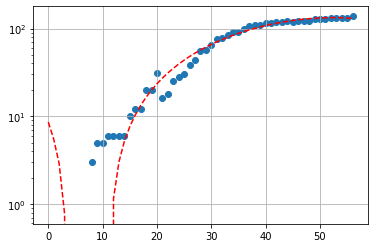

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.9099
Total cases up to today: 596
New cases registered today: 5
New cases registered today in %: 0.85
Doubling time in the last five days: 51.2
Doubling time yesterday: 49.5
Trend of new cases (in %) in the last 5 days: 7.0


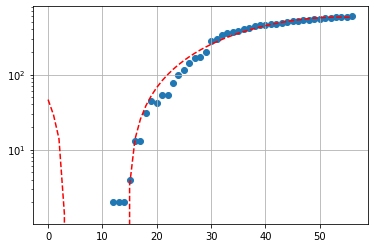

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 4.7809
Total cases up to today: 1122
New cases registered today: 14
New cases registered today in %: 1.26
Doubling time in the last five days: 22.4
Doubling time yesterday: 21.8
Trend of new cases (in %) in the last 5 days: 16.75


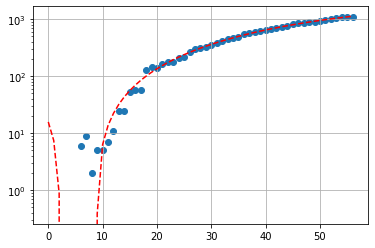

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.7217
Total cases up to today: 915
New cases registered today: 5
New cases registered today in %: 0.55
Doubling time in the last five days: 130.4
Doubling time yesterday: 156.0
Trend of new cases (in %) in the last 5 days: 2.69


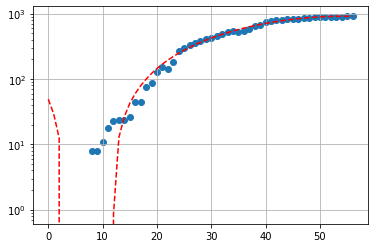

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 5732
New cases registered today: 58
New cases registered today in %: 1.02
Doubling time in the last five days: 33.3
Doubling time yesterday: 29.5
Trend of new cases (in %) in the last 5 days: 10.96


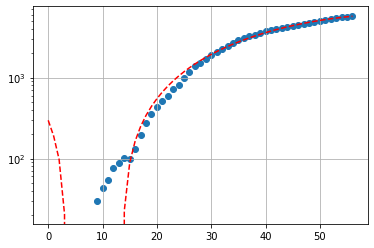

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 1.0648
Total cases up to today: 525
New cases registered today: 4
New cases registered today in %: 0.77
Doubling time in the last five days: 37.8
Doubling time yesterday: 35.9
Trend of new cases (in %) in the last 5 days: 9.6


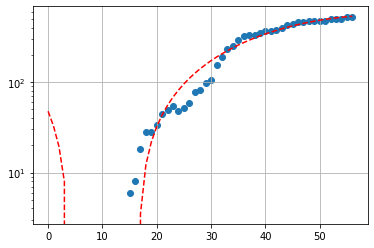

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.7723
Total cases up to today: 444
New cases registered today: 2
New cases registered today in %: 0.45
Doubling time in the last five days: 59.8
Doubling time yesterday: 46.1
Trend of new cases (in %) in the last 5 days: 5.97


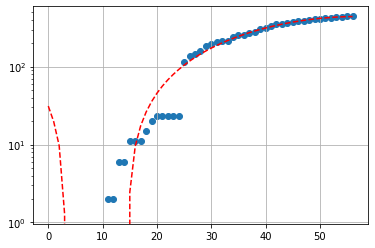

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 1.785
Total cases up to today: 281
New cases registered today: 1
New cases registered today in %: 0.36
Doubling time in the last five days: 241.7
Doubling time yesterday: 240.9
Trend of new cases (in %) in the last 5 days: 1.44


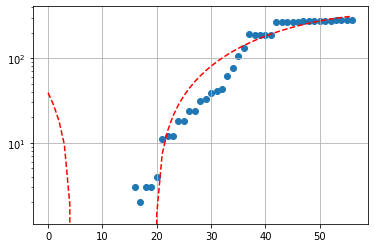

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.9493
Total cases up to today: 4133
New cases registered today: 51
New cases registered today in %: 1.25
Doubling time in the last five days: 28.8
Doubling time yesterday: 25.3
Trend of new cases (in %) in the last 5 days: 12.77


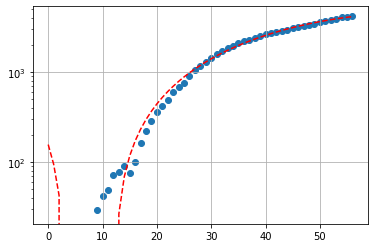

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 1.094
Total cases up to today: 349
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 50.8
Doubling time yesterday: 50.8
Trend of new cases (in %) in the last 5 days: 7.06


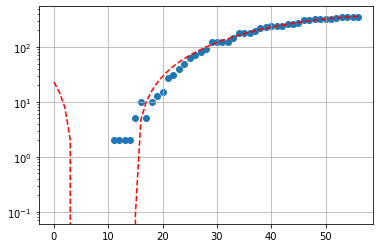

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 6662
New cases registered today: 141
New cases registered today in %: 2.16
Doubling time in the last five days: 30.0
Doubling time yesterday: 29.9
Trend of new cases (in %) in the last 5 days: 12.23


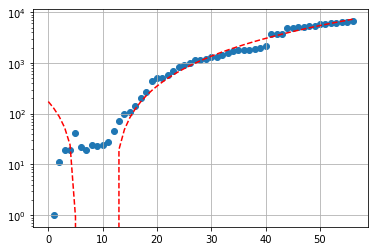

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 4.4608
Total cases up to today: 3792
New cases registered today: 86
New cases registered today in %: 2.32
Doubling time in the last five days: 41.3
Doubling time yesterday: 53.1
Trend of new cases (in %) in the last 5 days: 8.75


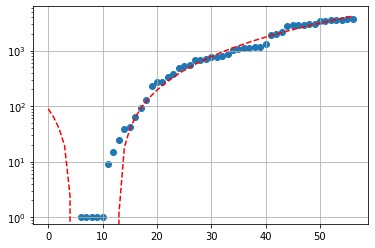

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 5.3735
Total cases up to today: 1156
New cases registered today: 34
New cases registered today in %: 3.03
Doubling time in the last five days: 31.6
Doubling time yesterday: 25.4
Trend of new cases (in %) in the last 5 days: 11.58


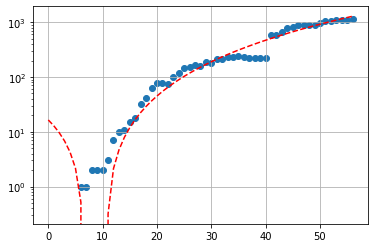

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 3.5206
Total cases up to today: 777
New cases registered today: 10
New cases registered today in %: 1.3
Doubling time in the last five days: 31.5
Doubling time yesterday: 23.1
Trend of new cases (in %) in the last 5 days: 11.64


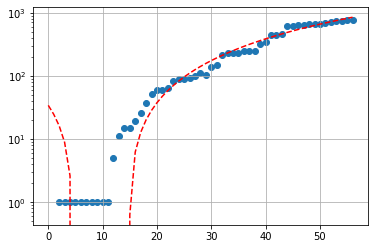

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 3.3535
Total cases up to today: 937
New cases registered today: 11
New cases registered today in %: 1.19
Doubling time in the last five days: 13.0
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 30.68


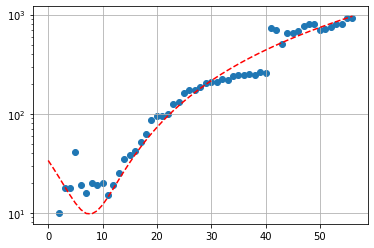

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 65582
New cases registered today: 722
New cases registered today in %: 1.11
Doubling time in the last five days: 46.3
Doubling time yesterday: 44.9
Trend of new cases (in %) in the last 5 days: 7.77


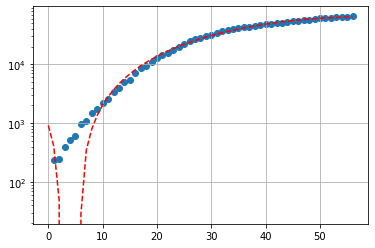

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 9.6745
Total cases up to today: 10738
New cases registered today: 49
New cases registered today in %: 0.46
Doubling time in the last five days: 138.2
Doubling time yesterday: 139.1
Trend of new cases (in %) in the last 5 days: 2.54


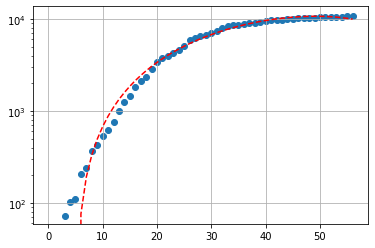

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 9.5095
Total cases up to today: 12004
New cases registered today: 58
New cases registered today in %: 0.49
Doubling time in the last five days: 49.2
Doubling time yesterday: 46.8
Trend of new cases (in %) in the last 5 days: 7.3


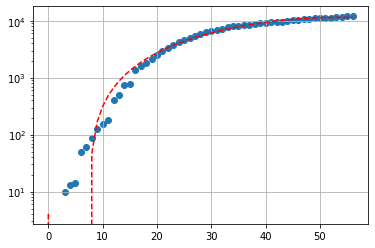

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 4.2487
Total cases up to today: 2550
New cases registered today: 62
New cases registered today in %: 2.49
Doubling time in the last five days: 20.5
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 18.38


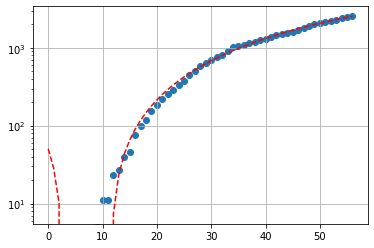

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 15.2788
Total cases up to today: 5491
New cases registered today: 74
New cases registered today in %: 1.37
Doubling time in the last five days: 64.1
Doubling time yesterday: 74.9
Trend of new cases (in %) in the last 5 days: 5.56


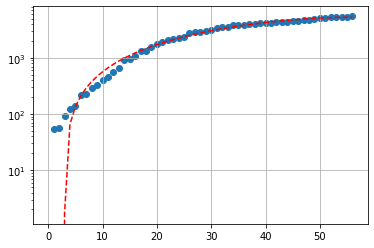

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 6.1314
Total cases up to today: 2080
New cases registered today: 8
New cases registered today in %: 0.39
Doubling time in the last five days: 71.8
Doubling time yesterday: 68.7
Trend of new cases (in %) in the last 5 days: 4.94


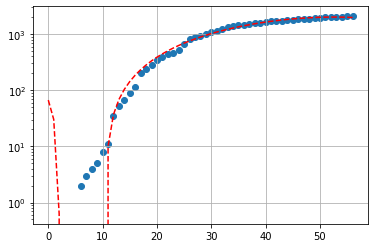

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 11.9474
Total cases up to today: 2740
New cases registered today: 16
New cases registered today in %: 0.59
Doubling time in the last five days: 60.3
Doubling time yesterday: 59.2
Trend of new cases (in %) in the last 5 days: 5.91


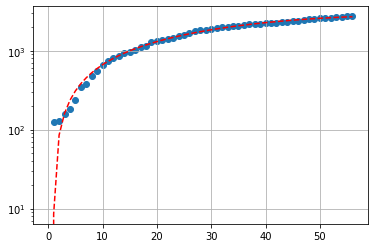

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 7.0599
Total cases up to today: 2913
New cases registered today: 8
New cases registered today in %: 0.28
Doubling time in the last five days: 37.4
Doubling time yesterday: 35.0
Trend of new cases (in %) in the last 5 days: 9.72


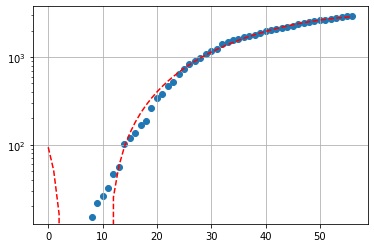

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 5.0065
Total cases up to today: 16112
New cases registered today: 287
New cases registered today in %: 1.81
Doubling time in the last five days: 37.1
Doubling time yesterday: 35.4
Trend of new cases (in %) in the last 5 days: 9.79


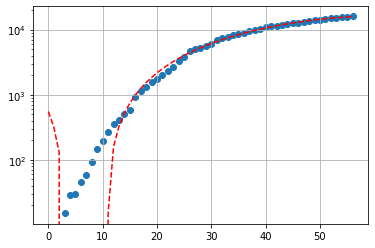

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 4.7844
Total cases up to today: 4157
New cases registered today: 59
New cases registered today in %: 1.44
Doubling time in the last five days: 49.9
Doubling time yesterday: 49.5
Trend of new cases (in %) in the last 5 days: 7.19


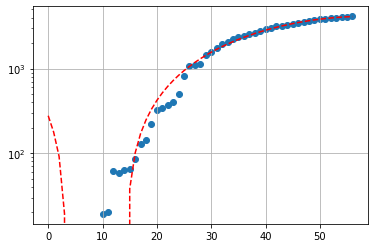

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 6.6533
Total cases up to today: 3641
New cases registered today: 59
New cases registered today in %: 1.65
Doubling time in the last five days: 37.1
Doubling time yesterday: 35.2
Trend of new cases (in %) in the last 5 days: 9.8


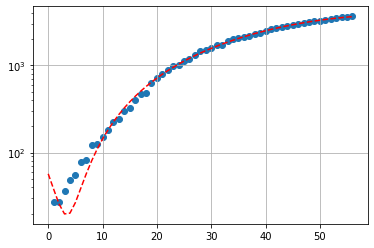

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 5.2911
Total cases up to today: 960
New cases registered today: 4
New cases registered today in %: 0.42
Doubling time in the last five days: 31.2
Doubling time yesterday: 29.2
Trend of new cases (in %) in the last 5 days: 11.76


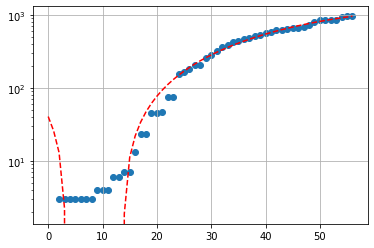

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 2.4673
Total cases up to today: 2196
New cases registered today: 38
New cases registered today in %: 1.76
Doubling time in the last five days: 22.6
Doubling time yesterday: 19.9
Trend of new cases (in %) in the last 5 days: 16.56


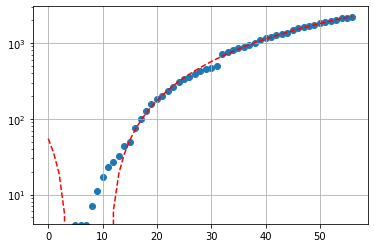

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 5654
New cases registered today: 55
New cases registered today in %: 0.98
Doubling time in the last five days: 62.5
Doubling time yesterday: 58.7
Trend of new cases (in %) in the last 5 days: 5.7


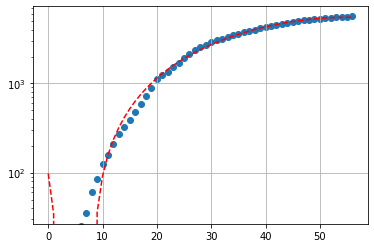

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 3.6636
Total cases up to today: 1737
New cases registered today: 19
New cases registered today in %: 1.11
Doubling time in the last five days: 65.1
Doubling time yesterday: 65.2
Trend of new cases (in %) in the last 5 days: 5.46


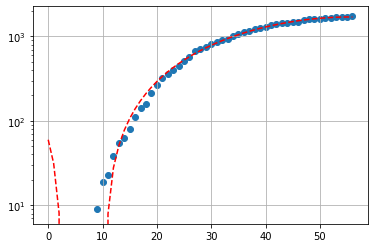

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 1.2939
Total cases up to today: 271
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 76.5
Doubling time yesterday: 53.5
Trend of new cases (in %) in the last 5 days: 4.63


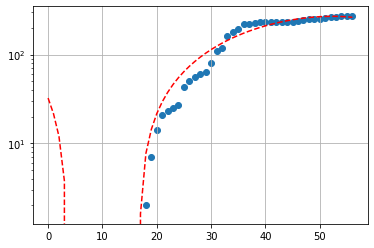

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 2.2362
Total cases up to today: 391
New cases registered today: 7
New cases registered today in %: 1.82
Doubling time in the last five days: 54.7
Doubling time yesterday: 61.6
Trend of new cases (in %) in the last 5 days: 6.54


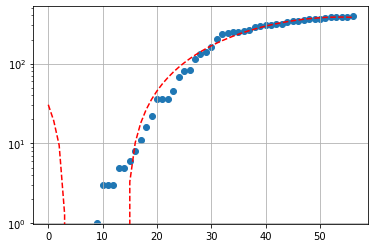

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 2.891
Total cases up to today: 922
New cases registered today: 8
New cases registered today in %: 0.88
Doubling time in the last five days: 40.3
Doubling time yesterday: 39.4
Trend of new cases (in %) in the last 5 days: 8.98


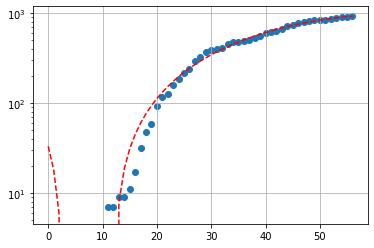

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 6.4678
Total cases up to today: 2333
New cases registered today: 21
New cases registered today in %: 0.91
Doubling time in the last five days: 76.8
Doubling time yesterday: 66.7
Trend of new cases (in %) in the last 5 days: 4.62


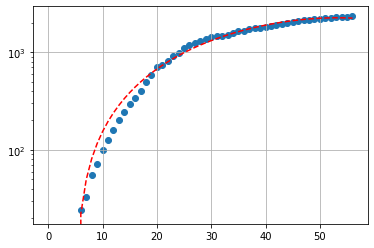

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in MoliseÂ¶

Total cases up to today: 263
New cases registered today: 2
New cases registered today in %: 0.77
Doubling time in the last five days: 55.2
Doubling time yesterday: 43.5
Trend of new cases (in %) in the last 5 days: 6.48


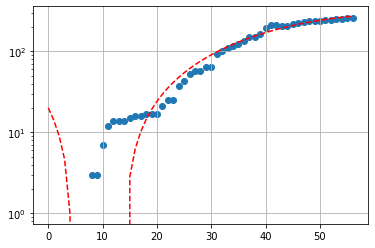

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.9437
Total cases up to today: 212
New cases registered today: 1
New cases registered today in %: 0.47
Doubling time in the last five days: 47.2
Doubling time yesterday: 34.8
Trend of new cases (in %) in the last 5 days: 7.61


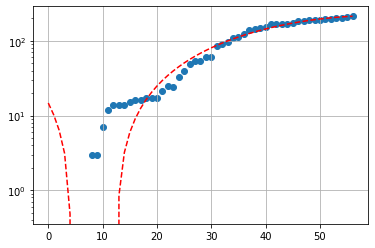

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.5944
Total cases up to today: 51
New cases registered today: 1
New cases registered today in %: 2.0
Doubling time in the last five days: 175.0
Doubling time yesterday: nan
Trend of new cases (in %) in the last 5 days: 2.0


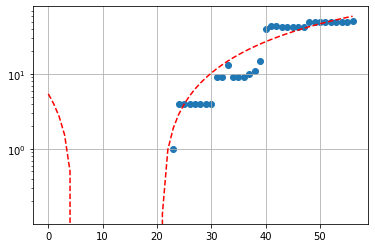

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 21014
New cases registered today: 290
New cases registered today in %: 1.4
Doubling time in the last five days: 21.8
Doubling time yesterday: 19.8
Trend of new cases (in %) in the last 5 days: 17.22


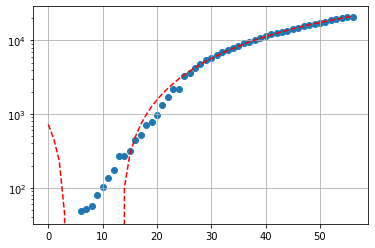

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 6.5978
Total cases up to today: 2815
New cases registered today: 32
New cases registered today in %: 1.15
Doubling time in the last five days: 22.1
Doubling time yesterday: 21.4
Trend of new cases (in %) in the last 5 days: 16.95


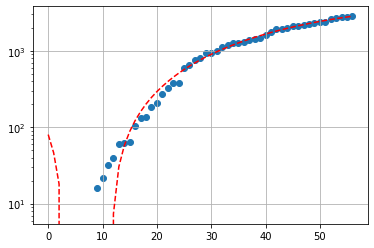

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 5.2705
Total cases up to today: 1142
New cases registered today: 78
New cases registered today in %: 7.33
Doubling time in the last five days: 14.4
Doubling time yesterday: 17.0
Trend of new cases (in %) in the last 5 days: 27.31


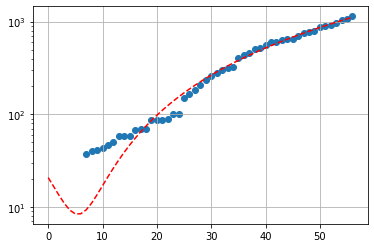

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 4.4077
Total cases up to today: 787
New cases registered today: 4
New cases registered today in %: 0.51
Doubling time in the last five days: 37.2
Doubling time yesterday: 31.7
Trend of new cases (in %) in the last 5 days: 9.76


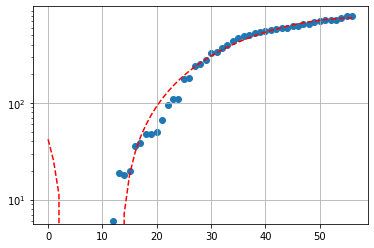

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 3.5223
Total cases up to today: 2075
New cases registered today: 22
New cases registered today in %: 1.07
Doubling time in the last five days: 23.5
Doubling time yesterday: 21.5
Trend of new cases (in %) in the last 5 days: 15.86


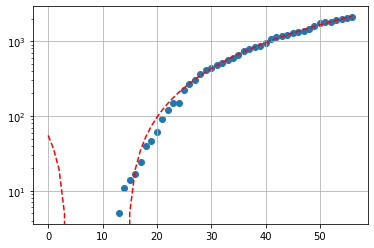

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 5.3925
Total cases up to today: 1996
New cases registered today: 9
New cases registered today in %: 0.45
Doubling time in the last five days: 22.2
Doubling time yesterday: 17.9
Trend of new cases (in %) in the last 5 days: 16.86


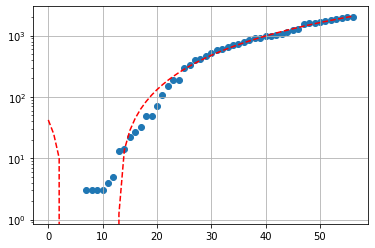

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 4.5121
Total cases up to today: 10278
New cases registered today: 134
New cases registered today in %: 1.32
Doubling time in the last five days: 20.2
Doubling time yesterday: 17.7
Trend of new cases (in %) in the last 5 days: 18.74


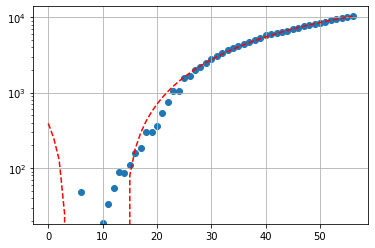

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 5.8686
Total cases up to today: 937
New cases registered today: 2
New cases registered today in %: 0.21
Doubling time in the last five days: 96.7
Doubling time yesterday: 75.4
Trend of new cases (in %) in the last 5 days: 3.65


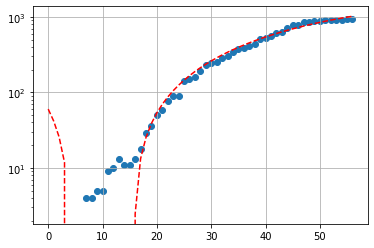

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 5.6595
Total cases up to today: 984
New cases registered today: 9
New cases registered today in %: 0.92
Doubling time in the last five days: 23.1
Doubling time yesterday: 23.1
Trend of new cases (in %) in the last 5 days: 16.17


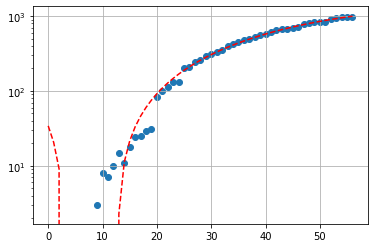

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 3536
New cases registered today: 61
New cases registered today in %: 1.76
Doubling time in the last five days: 30.4
Doubling time yesterday: 29.6
Trend of new cases (in %) in the last 5 days: 12.08


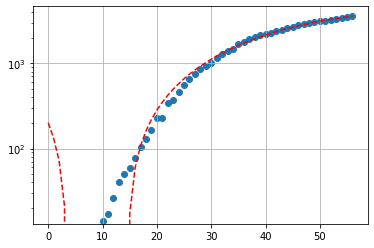

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.9031
Total cases up to today: 1138
New cases registered today: 28
New cases registered today in %: 2.52
Doubling time in the last five days: 29.8
Doubling time yesterday: 30.0
Trend of new cases (in %) in the last 5 days: 12.34


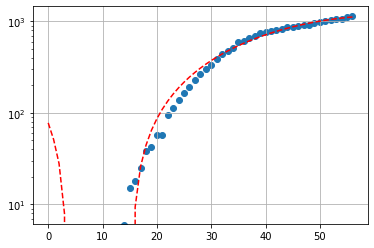

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.8534
Total cases up to today: 335
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 56.3
Doubling time yesterday: 38.3
Trend of new cases (in %) in the last 5 days: 6.35


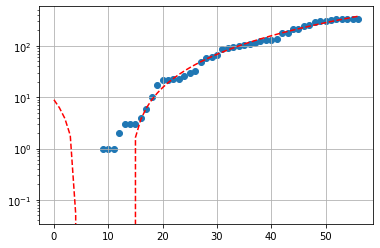

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 1.2592
Total cases up to today: 500
New cases registered today: 15
New cases registered today in %: 3.09
Doubling time in the last five days: 19.1
Doubling time yesterday: 18.7
Trend of new cases (in %) in the last 5 days: 19.9


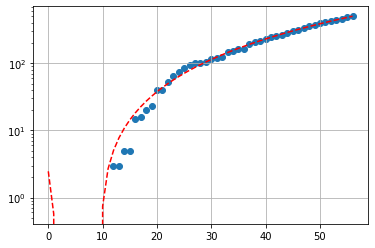

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 1.3809
Total cases up to today: 868
New cases registered today: 16
New cases registered today in %: 1.88
Doubling time in the last five days: 25.1
Doubling time yesterday: 25.1
Trend of new cases (in %) in the last 5 days: 14.81


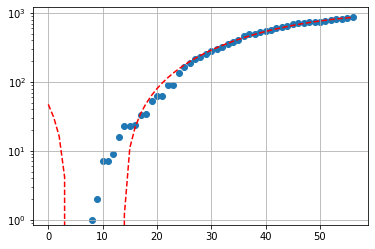

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.5635
Total cases up to today: 452
New cases registered today: 1
New cases registered today in %: 0.22
Doubling time in the last five days: 58.5
Doubling time yesterday: 58.4
Trend of new cases (in %) in the last 5 days: 6.1


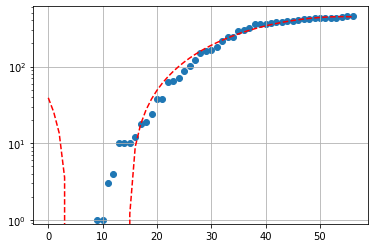

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.4165
Total cases up to today: 243
New cases registered today: 1
New cases registered today in %: 0.41
Doubling time in the last five days: 54.4
Doubling time yesterday: 50.7
Trend of new cases (in %) in the last 5 days: 6.58


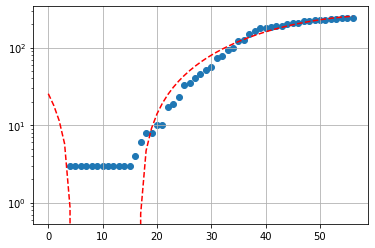

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 1228
New cases registered today: 13
New cases registered today in %: 1.07
Doubling time in the last five days: 61.8
Doubling time yesterday: 52.9
Trend of new cases (in %) in the last 5 days: 5.77


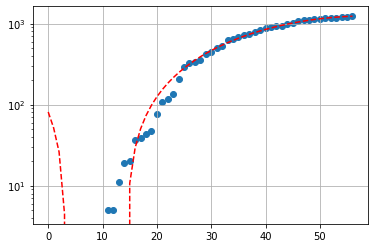

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.389
Total cases up to today: 218
New cases registered today: 1
New cases registered today in %: 0.46
Doubling time in the last five days: 66.9
Doubling time yesterday: 45.2
Trend of new cases (in %) in the last 5 days: 5.31


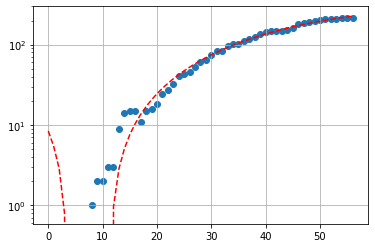

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.4741
Total cases up to today: 74
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 34.9
Doubling time yesterday: 34.9
Trend of new cases (in %) in the last 5 days: 10.45


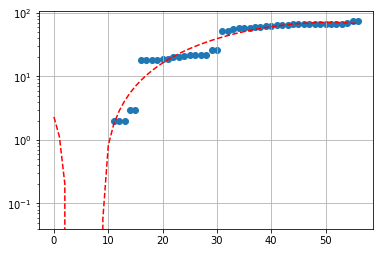

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.3235
Total cases up to today: 52
New cases registered today: 10
New cases registered today in %: 23.81
Doubling time in the last five days: 11.0
Doubling time yesterday: 19.0
Trend of new cases (in %) in the last 5 days: 36.84


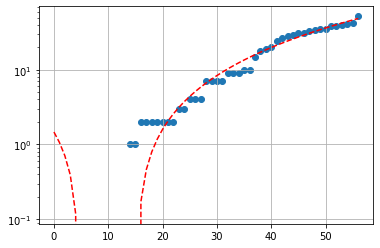

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 2.3956
Total cases up to today: 798
New cases registered today: 2
New cases registered today in %: 0.25
Doubling time in the last five days: 77.3
Doubling time yesterday: 56.9
Trend of new cases (in %) in the last 5 days: 4.59


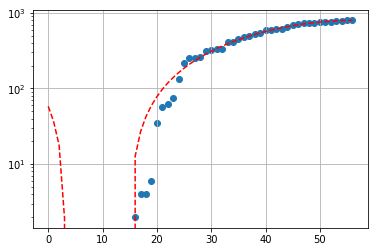

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 2759
New cases registered today: 42
New cases registered today in %: 1.55
Doubling time in the last five days: 40.9
Doubling time yesterday: 41.8
Trend of new cases (in %) in the last 5 days: 8.84


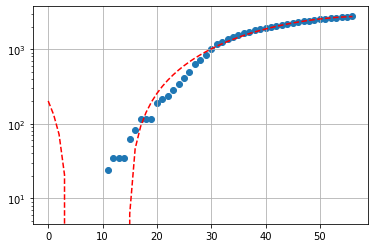

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.2986
Total cases up to today: 132
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 455.7
Doubling time yesterday: 227.0
Trend of new cases (in %) in the last 5 days: 0.76


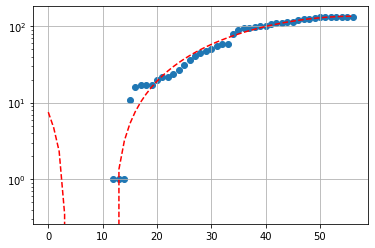

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.5117
Total cases up to today: 138
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 476.5
Doubling time yesterday: 157.7
Trend of new cases (in %) in the last 5 days: 0.73


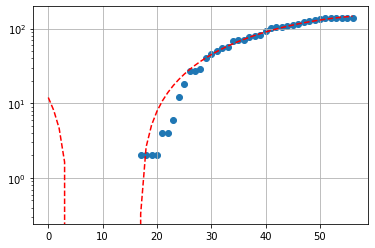

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.7258
Total cases up to today: 808
New cases registered today: 25
New cases registered today in %: 3.19
Doubling time in the last five days: 32.0
Doubling time yesterday: 38.1
Trend of new cases (in %) in the last 5 days: 11.45


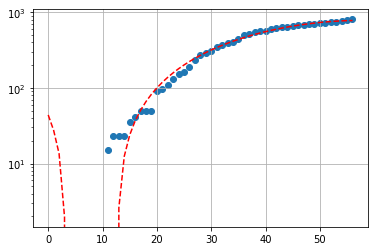

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 2.2434
Total cases up to today: 377
New cases registered today: 5
New cases registered today in %: 1.34
Doubling time in the last five days: 33.6
Doubling time yesterday: 33.1
Trend of new cases (in %) in the last 5 days: 10.88


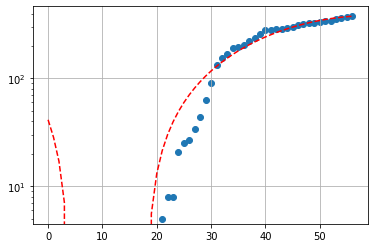

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.7806
Total cases up to today: 497
New cases registered today: 8
New cases registered today in %: 1.64
Doubling time in the last five days: 34.1
Doubling time yesterday: 32.1
Trend of new cases (in %) in the last 5 days: 10.69


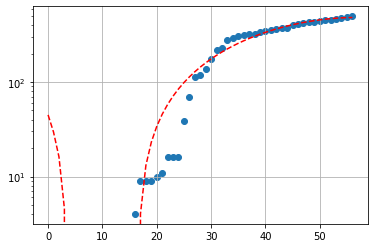

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.3312
Total cases up to today: 420
New cases registered today: 3
New cases registered today in %: 0.72
Doubling time in the last five days: 52.2
Doubling time yesterday: 53.8
Trend of new cases (in %) in the last 5 days: 6.87


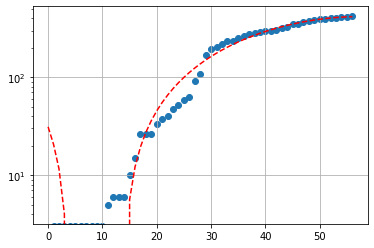

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.2147
Total cases up to today: 69
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 237.4
Doubling time yesterday: 117.8
Trend of new cases (in %) in the last 5 days: 1.47


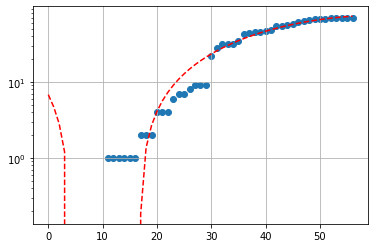

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.4543
Total cases up to today: 183
New cases registered today: 1
New cases registered today in %: 0.55
Doubling time in the last five days: 23.6
Doubling time yesterday: 22.5
Trend of new cases (in %) in the last 5 days: 15.82


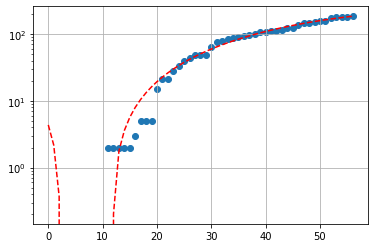

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.3107
Total cases up to today: 135
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 466.1
Doubling time yesterday: 232.2
Trend of new cases (in %) in the last 5 days: 0.75


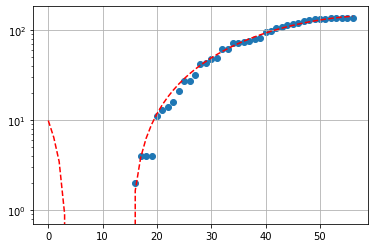

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 8507
New cases registered today: 135
New cases registered today in %: 1.61
Doubling time in the last five days: 33.3
Doubling time yesterday: 32.6
Trend of new cases (in %) in the last 5 days: 10.97


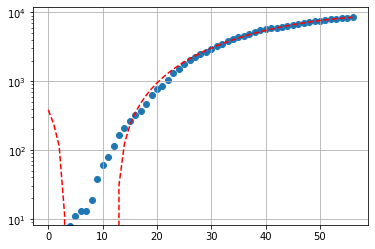

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 1.6465
Total cases up to today: 567
New cases registered today: 9
New cases registered today in %: 1.61
Doubling time in the last five days: 41.9
Doubling time yesterday: 25.5
Trend of new cases (in %) in the last 5 days: 8.62


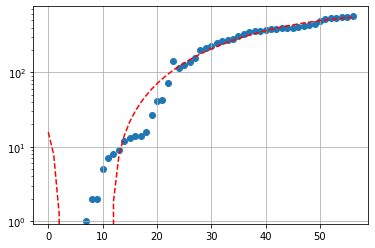

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 2.6153
Total cases up to today: 2653
New cases registered today: 44
New cases registered today in %: 1.69
Doubling time in the last five days: 31.0
Doubling time yesterday: 28.6
Trend of new cases (in %) in the last 5 days: 11.85


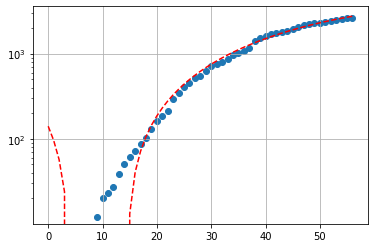

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.7171
Total cases up to today: 383
New cases registered today: 3
New cases registered today in %: 0.79
Doubling time in the last five days: 86.7
Doubling time yesterday: 108.0
Trend of new cases (in %) in the last 5 days: 4.08


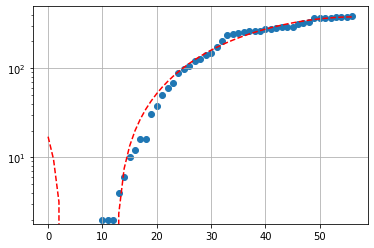

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 1.4555
Total cases up to today: 491
New cases registered today: 2
New cases registered today in %: 0.41
Doubling time in the last five days: 20.6
Doubling time yesterday: 19.7
Trend of new cases (in %) in the last 5 days: 18.31


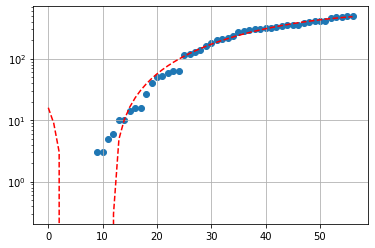

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 3.1099
Total cases up to today: 1213
New cases registered today: 16
New cases registered today in %: 1.34
Doubling time in the last five days: 28.3
Doubling time yesterday: 28.7
Trend of new cases (in %) in the last 5 days: 13.05


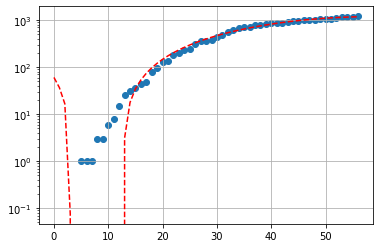

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 4.8276
Total cases up to today: 949
New cases registered today: 16
New cases registered today in %: 1.71
Doubling time in the last five days: 46.6
Doubling time yesterday: 52.1
Trend of new cases (in %) in the last 5 days: 7.72


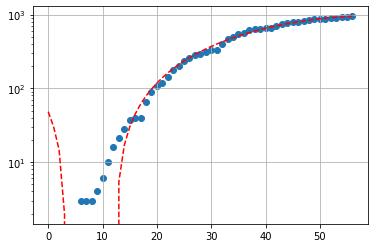

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.9059
Total cases up to today: 804
New cases registered today: 26
New cases registered today in %: 3.34
Doubling time in the last five days: 37.5
Doubling time yesterday: 51.1
Trend of new cases (in %) in the last 5 days: 9.69


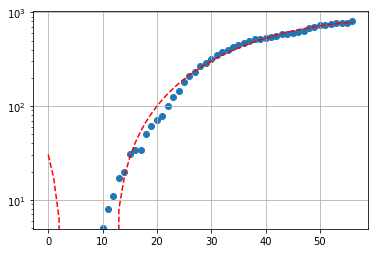

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.9463
Total cases up to today: 568
New cases registered today: 11
New cases registered today in %: 1.97
Doubling time in the last five days: 36.1
Doubling time yesterday: 42.1
Trend of new cases (in %) in the last 5 days: 10.08


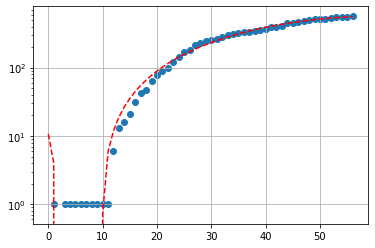

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 1.8538
Total cases up to today: 472
New cases registered today: 6
New cases registered today in %: 1.29
Doubling time in the last five days: 25.0
Doubling time yesterday: 24.3
Trend of new cases (in %) in the last 5 days: 14.84


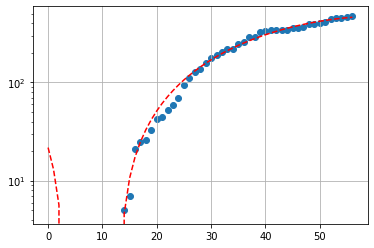

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.5167
Total cases up to today: 407
New cases registered today: 2
New cases registered today in %: 0.49
Doubling time in the last five days: 42.3
Doubling time yesterday: 42.1
Trend of new cases (in %) in the last 5 days: 8.53


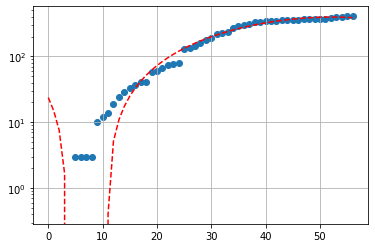

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 6.6654
Total cases up to today: 3590
New cases registered today: 58
New cases registered today in %: 1.64
Doubling time in the last five days: 31.9
Doubling time yesterday: 29.5
Trend of new cases (in %) in the last 5 days: 11.49


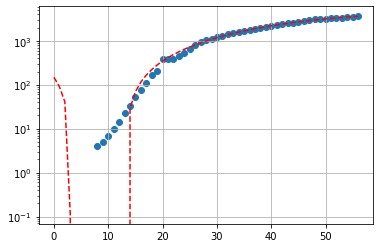

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 1304
New cases registered today: 1
New cases registered today in %: 0.08
Doubling time in the last five days: 154.1
Doubling time yesterday: 154.0
Trend of new cases (in %) in the last 5 days: 2.27


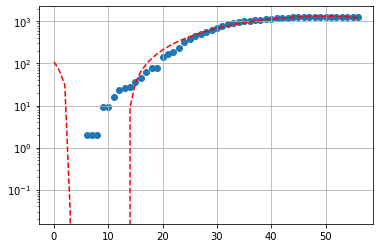

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.4772
Total cases up to today: 976
New cases registered today: 1
New cases registered today in %: 0.1
Doubling time in the last five days: 186.2
Doubling time yesterday: 186.0
Trend of new cases (in %) in the last 5 days: 1.88


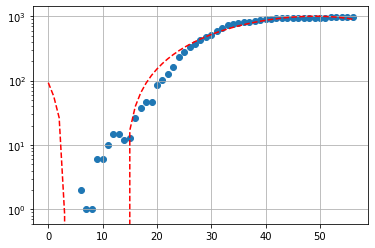

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 1.4372
Total cases up to today: 328
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 101.6
Doubling time yesterday: 101.6
Trend of new cases (in %) in the last 5 days: 3.47


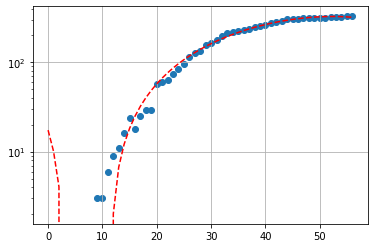

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 8.5748
Total cases up to today: 1088
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 27.2
Doubling time yesterday: 25.0
Trend of new cases (in %) in the last 5 days: 13.57


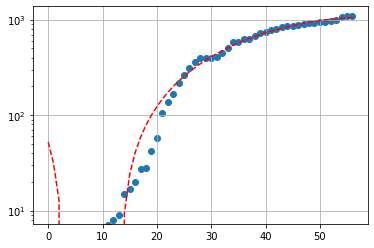

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 15783
New cases registered today: 183
New cases registered today in %: 1.17
Doubling time in the last five days: 35.0
Doubling time yesterday: 34.1
Trend of new cases (in %) in the last 5 days: 10.41


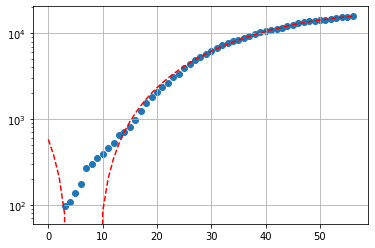

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 4.393
Total cases up to today: 904
New cases registered today: 48
New cases registered today in %: 5.61
Doubling time in the last five days: 15.5
Doubling time yesterday: 17.0
Trend of new cases (in %) in the last 5 days: 25.03


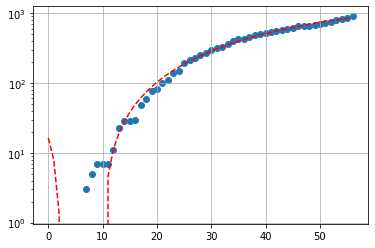

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 3.9444
Total cases up to today: 3693
New cases registered today: 26
New cases registered today in %: 0.71
Doubling time in the last five days: 50.9
Doubling time yesterday: 47.1
Trend of new cases (in %) in the last 5 days: 7.04


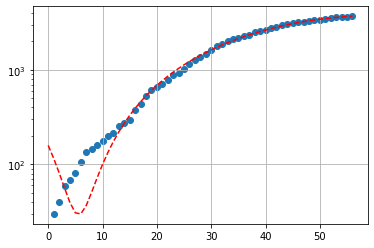

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 1.2867
Total cases up to today: 307
New cases registered today: 1
New cases registered today in %: 0.33
Doubling time in the last five days: 64.8
Doubling time yesterday: 54.1
Trend of new cases (in %) in the last 5 days: 5.5


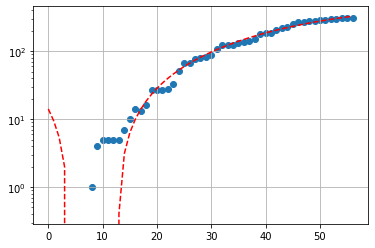

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 2.6242
Total cases up to today: 2325
New cases registered today: 10
New cases registered today in %: 0.43
Doubling time in the last five days: 25.8
Doubling time yesterday: 26.6
Trend of new cases (in %) in the last 5 days: 14.36


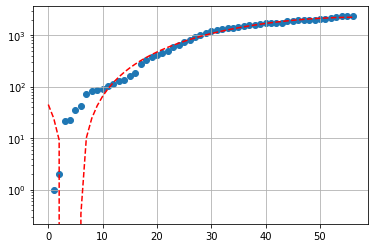

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 2.5484
Total cases up to today: 2177
New cases registered today: 34
New cases registered today in %: 1.59
Doubling time in the last five days: 44.3
Doubling time yesterday: 53.3
Trend of new cases (in %) in the last 5 days: 8.15


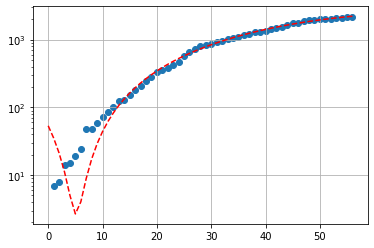

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 4.3383
Total cases up to today: 3998
New cases registered today: 24
New cases registered today in %: 0.6
Doubling time in the last five days: 37.9
Doubling time yesterday: 32.5
Trend of new cases (in %) in the last 5 days: 9.56


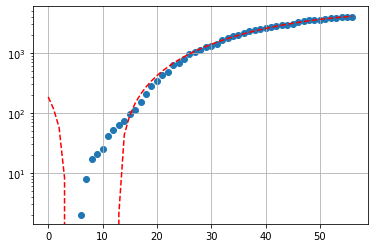

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 2.75
Total cases up to today: 2379
New cases registered today: 40
New cases registered today in %: 1.71
Doubling time in the last five days: 32.2
Doubling time yesterday: 30.7
Trend of new cases (in %) in the last 5 days: 11.38


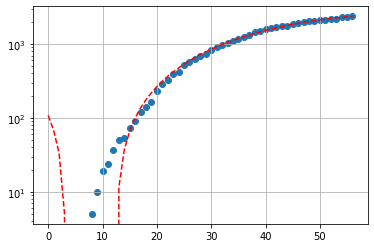

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')